In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [5]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=55e8a7f394f1bc8d95e2e00bdb09b5d6bfee1020392e53dd51329d2ae1732d77
  Stored in directory: c:\users\k k's notebook\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus :
#  tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

0

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [5]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [25]:
import uuid

In [27]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[120:370, 200:450, :]
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

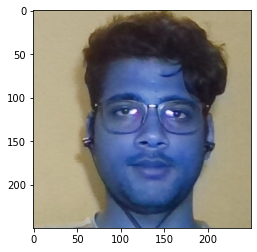

In [24]:
plt.imshow(frame)

In [22]:
frame.shape

(250, 250, 3)

In [29]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(50)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(50)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(50)

In [30]:
dir_test = anchor.as_numpy_iterator()

In [32]:
dir_test.next()

b'data\\anchor\\ba077c7a-a054-11ec-8683-68545a90d15b.jpg'

In [33]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    return img

In [34]:
img = preprocess('data\\anchor\\ba077c7a-a054-11ec-8683-68545a90d15b.jpg')

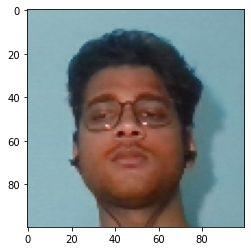

In [36]:
plt.imshow(img)

In [37]:
img.numpy().min()

0.0004901961

In [38]:
img.numpy().max()

1.0

In [40]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [41]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [42]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [43]:
samples = data.as_numpy_iterator()

In [44]:
samples.next()

(b'data\\anchor\\b17eb712-a054-11ec-84fa-68545a90d15b.jpg',
 b'data\\positive\\b541112d-a053-11ec-9329-68545a90d15b.jpg',
 1.0)

In [45]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [46]:
example = samples.next()

In [47]:
example

(b'data\\anchor\\b101ee00-a054-11ec-a259-68545a90d15b.jpg',
 b'data\\positive\\d6dbbc66-a054-11ec-95cb-68545a90d15b.jpg',
 1.0)

In [49]:
res = preprocess_twin(*example)

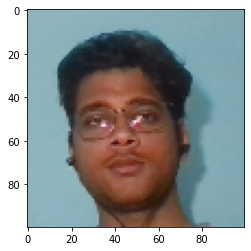

In [50]:
plt.imshow(res[0])

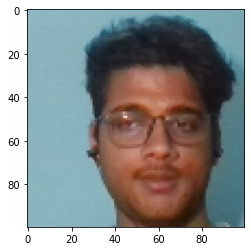

In [51]:
plt.imshow(res[1])

In [52]:
res[2]

1.0

In [53]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [54]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [55]:
samples = data.as_numpy_iterator()

In [56]:
len(samples.next())

3

In [58]:
samples.next()[0]

array([[[0.5803922 , 0.7137255 , 0.7529412 ],
        [0.58210784, 0.71544117, 0.75465685],
        [0.5835784 , 0.7169118 , 0.7561275 ],
        ...,
        [0.5088235 , 0.6578431 , 0.70098037],
        [0.49803922, 0.64705884, 0.6901961 ],
        [0.5019608 , 0.6509804 , 0.69411767]],

       [[0.58137256, 0.7147059 , 0.75392157],
        [0.5754902 , 0.7088235 , 0.7480392 ],
        [0.58235294, 0.71568626, 0.75490195],
        ...,
        [0.5012255 , 0.6502451 , 0.6933824 ],
        [0.49509802, 0.64411765, 0.6872549 ],
        [0.49803922, 0.64705884, 0.6901961 ]],

       [[0.5803922 , 0.7137255 , 0.7529412 ],
        [0.5754902 , 0.7088235 , 0.7480392 ],
        [0.5764706 , 0.70980394, 0.7490196 ],
        ...,
        [0.50980395, 0.65882355, 0.7019608 ],
        [0.5       , 0.6490196 , 0.69215685],
        [0.5019608 , 0.6509804 , 0.69411767]],

       ...,

       [[0.5497549 , 0.6987745 , 0.73406863],
        [0.54632354, 0.69534314, 0.73063725],
        [0.5509804 , 0

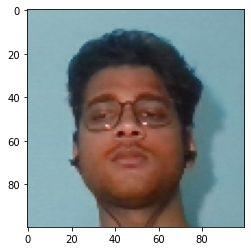

In [59]:
plt.imshow(samples.next()[0])

In [60]:
samp = samples.next()

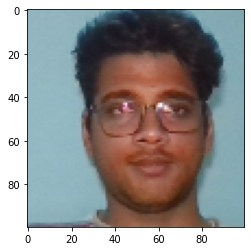

In [61]:
plt.imshow(samp[0])

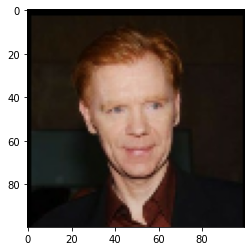

In [62]:
plt.imshow(samp[1])

In [63]:
samp[2]

0.0

In [64]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [65]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [66]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [67]:
train_samples = train_data.as_numpy_iterator()

In [68]:
train_samples = train_samples.next()

In [69]:
len(train_samples[0])

16

In [70]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [71]:
len(train_data)

5

In [72]:
inp = Input(shape=(100,100,3), name='input_image')
    
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
model = Model(inputs=[inp], outputs=[d1], name='embedding')

In [75]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [76]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [79]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [80]:
l1 = L1Dist()

In [81]:
l1

In [84]:
l1(anchor_embedding, validation_embedding)

In [85]:
input_image = Input(name='input_img', shape=(100,100,3))

In [89]:
validation_image = Input(name='validation_img', shape=(100,100,3))

In [91]:
inp_embedding = model(input_image)
val_embedding = model(validation_image)

In [86]:
model(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [92]:
siamese_layer = L1Dist()
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [98]:
distances = siamese_layer(model(input_image), model(validation_image))
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [101]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='siameseNetwork')
siamese_network.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [97]:
def make_siamese_model():
    input_image = Input(name='input_img', shape = (100,100,3))
    
    validation_image = Input(name = 'validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer.__name = 'distance'
    distances = siamese_layer(model(input_image), model(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siameseNetwork')

In [103]:
siamese_model = make_siamese_model()

In [104]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [105]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [107]:
opt = tf.keras.optimizers.Adam(1e-4)

In [109]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [111]:
test_batch  = train_data.as_numpy_iterator()

In [113]:
batch_1 = test_batch.next()

In [114]:
batch_1

(array([[[[0.57941175, 0.7127451 , 0.7519608 ],
          [0.5762255 , 0.70955884, 0.7487745 ],
          [0.5708333 , 0.70416665, 0.74338233],
          ...,
          [0.5115196 , 0.6605392 , 0.6958333 ],
          [0.5129902 , 0.6620098 , 0.69730395],
          [0.5156863 , 0.6647059 , 0.7       ]],
 
         [[0.5752451 , 0.7085784 , 0.7477941 ],
          [0.5735294 , 0.70686275, 0.74607843],
          [0.5686275 , 0.7019608 , 0.7411765 ],
          ...,
          [0.5058824 , 0.654902  , 0.6901961 ],
          [0.50980395, 0.65882355, 0.69411767],
          [0.5117647 , 0.6607843 , 0.6960784 ]],
 
         [[0.5735294 , 0.70686275, 0.74607843],
          [0.5772059 , 0.7105392 , 0.7497549 ],
          [0.5754902 , 0.7088235 , 0.7480392 ],
          ...,
          [0.50980395, 0.65882355, 0.69411767],
          [0.51740193, 0.6664216 , 0.7017157 ],
          [0.50980395, 0.65882355, 0.69411767]],
 
         ...,
 
         [[0.5536765 , 0.7026961 , 0.74583334],
          [0.55294

In [115]:
len(batch_1)

3

In [116]:
batch_1[0]

array([[[[0.57941175, 0.7127451 , 0.7519608 ],
         [0.5762255 , 0.70955884, 0.7487745 ],
         [0.5708333 , 0.70416665, 0.74338233],
         ...,
         [0.5115196 , 0.6605392 , 0.6958333 ],
         [0.5129902 , 0.6620098 , 0.69730395],
         [0.5156863 , 0.6647059 , 0.7       ]],

        [[0.5752451 , 0.7085784 , 0.7477941 ],
         [0.5735294 , 0.70686275, 0.74607843],
         [0.5686275 , 0.7019608 , 0.7411765 ],
         ...,
         [0.5058824 , 0.654902  , 0.6901961 ],
         [0.50980395, 0.65882355, 0.69411767],
         [0.5117647 , 0.6607843 , 0.6960784 ]],

        [[0.5735294 , 0.70686275, 0.74607843],
         [0.5772059 , 0.7105392 , 0.7497549 ],
         [0.5754902 , 0.7088235 , 0.7480392 ],
         ...,
         [0.50980395, 0.65882355, 0.69411767],
         [0.51740193, 0.6664216 , 0.7017157 ],
         [0.50980395, 0.65882355, 0.69411767]],

        ...,

        [[0.5536765 , 0.7026961 , 0.74583334],
         [0.5529412 , 0.7019608 , 0.74509805]

In [117]:
batch_1[1]

array([[[[0.5688726 , 0.71789217, 0.7610294 ],
         [0.57230395, 0.72132355, 0.7644608 ],
         [0.57254905, 0.72156864, 0.7647059 ],
         ...,
         [0.49019608, 0.654902  , 0.7019608 ],
         [0.4862745 , 0.6509804 , 0.69803923],
         [0.49411765, 0.65882355, 0.7058824 ]],

        [[0.5644608 , 0.7134804 , 0.75661767],
         [0.5588235 , 0.7078431 , 0.7509804 ],
         [0.5686275 , 0.7176471 , 0.7607843 ],
         ...,
         [0.49509802, 0.6607843 , 0.70490193],
         [0.49044117, 0.65833336, 0.6958333 ],
         [0.4970588 , 0.66568625, 0.70098037]],

        [[0.5715686 , 0.7205882 , 0.7637255 ],
         [0.5686275 , 0.7176471 , 0.7607843 ],
         [0.5732843 , 0.7223039 , 0.7654412 ],
         ...,
         [0.5019608 , 0.67058825, 0.7       ],
         [0.49117646, 0.6598039 , 0.6936275 ],
         [0.49019608, 0.65882355, 0.69411767]],

        ...,

        [[0.5421569 , 0.7107843 , 0.74607843],
         [0.5379902 , 0.70661765, 0.74191177]

In [118]:
len(batch_1[1])

16

In [119]:
X = batch_1[:2]

In [120]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [121]:
y = batch_1[2]
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [153]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y=batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [159]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            

In [160]:
EPOCHS = 10

In [161]:
train(train_data, EPOCHS)


 Epoch 1/10
5/5 [==============================] - 63s 12s/step

 Epoch 2/10
5/5 [==============================] - 62s 12s/step

 Epoch 3/10
5/5 [==============================] - 63s 12s/step

 Epoch 4/10
5/5 [==============================] - 62s 12s/step

 Epoch 5/10
5/5 [==============================] - 62s 12s/step

 Epoch 6/10
5/5 [==============================] - 62s 12s/step

 Epoch 7/10
5/5 [==============================] - 62s 12s/step

 Epoch 8/10
5/5 [==============================] - 62s 12s/step

 Epoch 9/10
5/5 [==============================] - 63s 12s/step

 Epoch 10/10
5/5 [==============================] - 63s 12s/step


In [162]:
from tensorflow.keras.metrics import Precision, Recall

In [172]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [173]:
test_var = test_data.as_numpy_iterator().next()

In [174]:
test_var

(array([[[[0.56911767, 0.7142157 , 0.7495098 ],
          [0.57058823, 0.71568626, 0.7509804 ],
          [0.5803922 , 0.7254902 , 0.7607843 ],
          ...,
          [0.5       , 0.6490196 , 0.69215685],
          [0.5058824 , 0.654902  , 0.69803923],
          [0.50490195, 0.65392154, 0.6970588 ]],
 
         [[0.56960785, 0.7117647 , 0.7480392 ],
          [0.5686275 , 0.7107843 , 0.7470588 ],
          [0.56985295, 0.7120098 , 0.74828434],
          ...,
          [0.49583334, 0.64485294, 0.6879902 ],
          [0.5026961 , 0.6517157 , 0.69485295],
          [0.5       , 0.6490196 , 0.69215685]],
 
         [[0.5735294 , 0.70686275, 0.74607843],
          [0.56911767, 0.702451  , 0.7416667 ],
          [0.56764704, 0.70098037, 0.74019605],
          ...,
          [0.49509802, 0.64411765, 0.6872549 ],
          [0.4997549 , 0.6487745 , 0.69191176],
          [0.4970588 , 0.6460784 , 0.68921566]],
 
         ...,
 
         [[0.54607844, 0.69509804, 0.7382353 ],
          [0.54779

In [175]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9914974e-01],
       [9.9294484e-05],
       [2.3295561e-05],
       [5.0699909e-05],
       [9.9743360e-01],
       [6.1177261e-06],
       [9.9860698e-01],
       [2.2043082e-06],
       [9.9966526e-01],
       [9.9997073e-01],
       [1.0617847e-05],
       [9.9996459e-01],
       [9.9993014e-01],
       [1.5306473e-04],
       [9.9861628e-01],
       [9.9961960e-01]], dtype=float32)

In [176]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]

In [177]:
res = []
for prediction in y_hat:
    if prediction >0.5:
        res.append(1)
    else:
        res.append(0)

In [178]:
res

[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]

In [179]:
y_true

array([1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [180]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [181]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

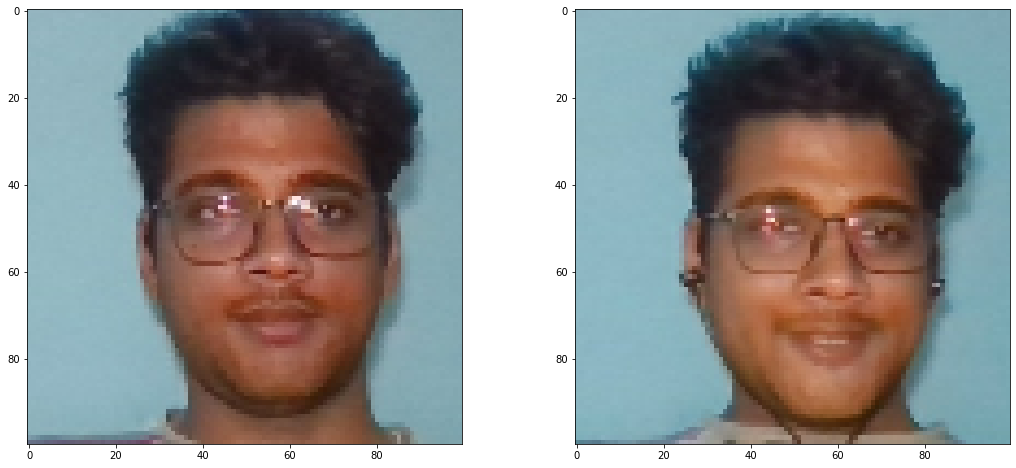

In [182]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

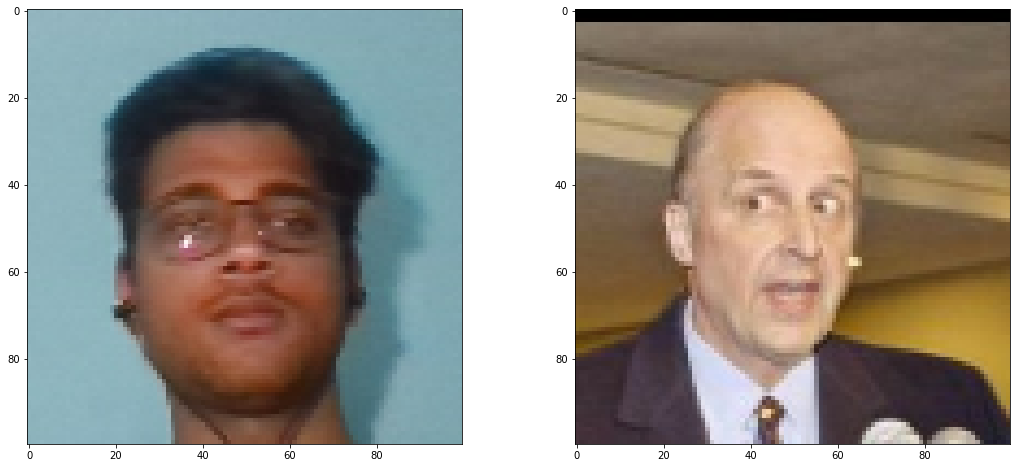

In [183]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

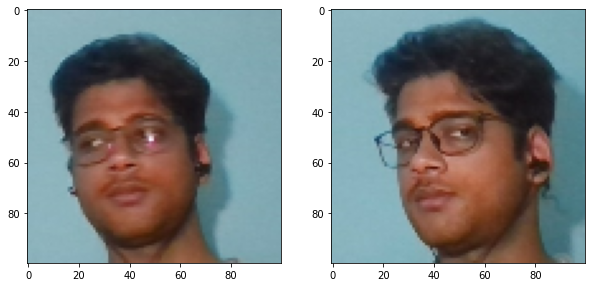

In [185]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[4])
plt.subplot(1,2,2)
plt.imshow(test_val[4])
plt.show()

In [186]:
siamese_model.save('siamesemodel.h5')

In [188]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [189]:
model.predict([test_input, test_val])

array([[9.9914974e-01],
       [9.9294484e-05],
       [2.3295561e-05],
       [5.0699909e-05],
       [9.9743360e-01],
       [6.1177261e-06],
       [9.9860698e-01],
       [2.2043082e-06],
       [9.9966526e-01],
       [9.9997073e-01],
       [1.0617847e-05],
       [9.9996459e-01],
       [9.9993014e-01],
       [1.5306473e-04],
       [9.9861628e-01],
       [9.9961960e-01]], dtype=float32)